In [2]:
%matplotlib inline

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gym
from collections import deque
import cv2
import matplotlib.pyplot as plt
import os

In [ ]:
!wget -P . http://www.atarimania.com/roms/Roms.rar
!unrar e ./Roms.rar
!unzip ROMS.zip
!python -m atari_py.import_roms ./ROMS

In [4]:
def plot_learning_curve(x, scores, epsilons, lines=None):
    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, epsilons, color="C0")
    ax.set_xlabel("Training Steps", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
	    running_avg[t] = np.mean(scores[max(0, t-20):(t+1)])

    ax2.scatter(x, running_avg, color="C1")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    ax2.set_ylabel('Score', color="C1")
    ax2.yaxis.set_label_position('right')
    ax2.tick_params(axis='y', colors="C1")

    if lines is not None:
        for line in lines:
            plt.axvline(x=line)
    plt.show()

In [5]:
class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape),
                                     dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_shape),
                                         dtype=np.float32)

        self.action_memory = np.zeros(self.mem_size, dtype=np.int64)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

In [6]:
class RepeatActionAndMaxFrame(gym.Wrapper):
    def __init__(self, env=None, repeat=4, clip_reward=False, no_ops=0,
                 fire_first=False):
        super(RepeatActionAndMaxFrame, self).__init__(env)
        self.repeat = repeat
        self.shape = env.observation_space.low.shape
        self.frame_buffer = np.zeros_like((2, self.shape))
        self.clip_reward = clip_reward
        self.no_ops = no_ops
        self.fire_first = fire_first

    def step(self, action):
        t_reward = 0.0
        done = False
        for i in range(self.repeat):
            obs, reward, done, info = self.env.step(action)
            if self.clip_reward:
                reward = np.clip(np.array([reward]), -1, 1)[0]
            t_reward += reward
            idx = i % 2
            self.frame_buffer[idx] = obs
            if done:
                break

        max_frame = np.maximum(self.frame_buffer[0], self.frame_buffer[1])
        return max_frame, t_reward, done, info

    def reset(self):
        obs = self.env.reset()
        no_ops = np.random.randint(self.no_ops)+1 if self.no_ops > 0 else 0
        for _ in range(no_ops):
            _, _, done, _ = self.env.step(0)
            if done:
                self.env.reset()
        if self.fire_first:
            assert self.env.unwrapped.get_action_meanings()[1] == 'FIRE'
            obs, _, _, _ = self.env.step(1)

        self.frame_buffer = np.zeros_like((2,self.shape))
        self.frame_buffer[0] = obs

        return obs

In [7]:
class PreprocessFrame(gym.ObservationWrapper):
    def __init__(self, shape, env=None):
        super(PreprocessFrame, self).__init__(env)
        self.shape = (shape[2], shape[0], shape[1])
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0,
                                    shape=self.shape, dtype=np.float32)

    def observation(self, obs):
        new_frame = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
        resized_screen = cv2.resize(new_frame, self.shape[1:],
                                    interpolation=cv2.INTER_AREA)
        new_obs = np.array(resized_screen, dtype=np.uint8).reshape(self.shape)
        new_obs = new_obs / 255.0

        return new_obs

In [8]:
class StackFrames(gym.ObservationWrapper):
    def __init__(self, env, repeat):
        super(StackFrames, self).__init__(env)
        self.observation_space = gym.spaces.Box(
                            env.observation_space.low.repeat(repeat, axis=0),
                            env.observation_space.high.repeat(repeat, axis=0),
                            dtype=np.float32)
        self.stack = deque(maxlen=repeat)

    def reset(self):
        self.stack.clear()
        observation = self.env.reset()
        for _ in range(self.stack.maxlen):
            self.stack.append(observation)

        return np.array(self.stack).reshape(self.observation_space.low.shape)

    def observation(self, observation):
        self.stack.append(observation)

        return np.array(self.stack).reshape(self.observation_space.low.shape)

In [9]:
def make_env(env_name, shape=(84,84,1), repeat=4, clip_rewards=False,
             no_ops=0, fire_first=False):
    env = gym.make(env_name)
    env = RepeatActionAndMaxFrame(env, repeat, clip_rewards, no_ops, fire_first)
    env = PreprocessFrame(shape, env)
    env = StackFrames(env, repeat)

    return env

In [10]:
class DeepQNetwork(nn.Module):
    def __init__(self, lr, n_actions, name, input_dims, chkpt_dir):
        super(DeepQNetwork, self).__init__()
        self.checkpoint_file = os.path.join(chkpt_dir, name)

        self.conv1 = nn.Conv2d(input_dims[0], 32, 8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1)

        fc_input_dims = self.calculate_conv_output_dims(input_dims)

        self.fc1 = nn.Linear(fc_input_dims, 512)
        self.A = nn.Linear(512, n_actions)
        self.V = nn.Linear(512, 1)

        self.optimizer = optim.RMSprop(self.parameters(), lr=lr)

        self.loss = nn.MSELoss()
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def calculate_conv_output_dims(self, input_dims):
        state = torch.zeros(1, *input_dims)
        dims = self.conv1(state)
        dims = self.conv2(dims)
        dims = self.conv3(dims)
        return int(np.prod(dims.size()))

    def forward(self, state):
        conv1 = F.relu(self.conv1(state))
        conv2 = F.relu(self.conv2(conv1))
        conv3 = F.relu(self.conv3(conv2))
        # conv3 shape is BS x n_filters x H x W
        conv_state = conv3.view(conv3.size()[0], -1)
        # conv_state shape is BS x (n_filters * H * W)
        flat1 = F.relu(self.fc1(conv_state))
        V = self.V(flat1)
        A = self.A(flat1)

        return V, A

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(torch.load(self.checkpoint_file))

In [11]:
class DualDQNAgent(object):
    def __init__(self, gamma, epsilon, lr, n_actions, input_dims,
                 mem_size, batch_size, eps_min=0.01, eps_dec=5e-7,
                 replace=1000, algo=None, env_name=None, chkpt_dir='tmp/dqn'):
        self.gamma = gamma
        self.epsilon = epsilon
        self.lr = lr
        self.n_actions = n_actions
        self.input_dims = input_dims
        self.batch_size = batch_size
        self.eps_min = eps_min
        self.eps_dec = eps_dec
        self.replace_target_cnt = replace
        self.algo = algo
        self.env_name = env_name
        self.chkpt_dir = chkpt_dir
        self.action_space = [i for i in range(n_actions)]
        self.learn_step_counter = 0

        self.memory = ReplayBuffer(mem_size, input_dims, n_actions)

        self.q_eval = DeepQNetwork(self.lr, self.n_actions,
                                    input_dims=self.input_dims,
                                    name=self.env_name+'_'+self.algo+'_q_eval',
                                    chkpt_dir=self.chkpt_dir)

        self.q_next = DeepQNetwork(self.lr, self.n_actions,
                                    input_dims=self.input_dims,
                                    name=self.env_name+'_'+self.algo+'_q_next',
                                    chkpt_dir=self.chkpt_dir)

    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            state = torch.tensor([observation],dtype=torch.float).to(self.q_eval.device)
            _, actions = self.q_eval.forward(state)
            action = torch.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)

        return action

    def store_transition(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)

    def sample_memory(self):
        state, action, reward, new_state, done = \
                                self.memory.sample_buffer(self.batch_size)

        states = torch.tensor(state).to(self.q_eval.device)
        rewards = torch.tensor(reward).to(self.q_eval.device)
        dones = torch.tensor(done).to(self.q_eval.device)
        actions = torch.tensor(action).to(self.q_eval.device)
        states_ = torch.tensor(new_state).to(self.q_eval.device)

        return states, actions, rewards, states_, dones

    def replace_target_network(self):
        if self.learn_step_counter % self.replace_target_cnt == 0:
            self.q_next.load_state_dict(self.q_eval.state_dict())

    def decrement_epsilon(self):
        self.epsilon = self.epsilon - self.eps_dec \
                           if self.epsilon > self.eps_min else self.eps_min

    def save_models(self):
        self.q_eval.save_checkpoint()
        self.q_next.save_checkpoint()

    def load_models(self):
        self.q_eval.load_checkpoint()
        self.q_next.load_checkpoint()

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        self.q_eval.optimizer.zero_grad()

        self.replace_target_network()

        states, actions, rewards, states_, dones = self.sample_memory()
        indices = np.arange(self.batch_size)

        V_pred, A_pred = self.q_eval.forward(states)
        V_next, A_next = self.q_eval.forward(states_)

        q_pred = torch.add(V_pred, (A_pred-A_pred.mean(dim=1, keepdim=True)))[indices, actions]
        q_next = torch.add(V_next, (A_next-A_next.mean(dim=1, keepdim=True))).max(dim=1)[0]

        q_next[dones] = 0.0
        q_target = rewards + self.gamma*q_next

        loss = self.q_eval.loss(q_target, q_pred).to(self.q_eval.device)
        loss.backward()
        self.q_eval.optimizer.step()
        self.learn_step_counter += 1

        self.decrement_epsilon()


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


episode:  0 score:  -19.0  average score -19.0 best score -inf epsilon 0.99 steps 994
... saving checkpoint ...
... saving checkpoint ...


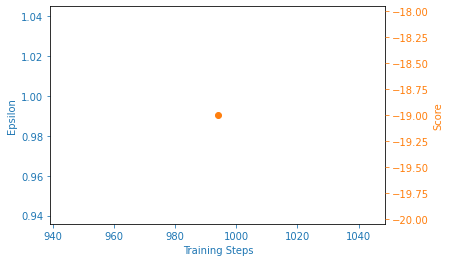

episode:  1 score:  -21.0  average score -20.0 best score -19.00 epsilon 0.98 steps 1814


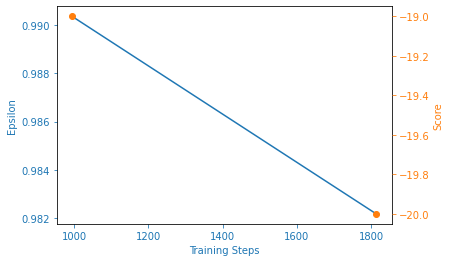

episode:  2 score:  -19.0  average score -19.7 best score -19.00 epsilon 0.97 steps 2853


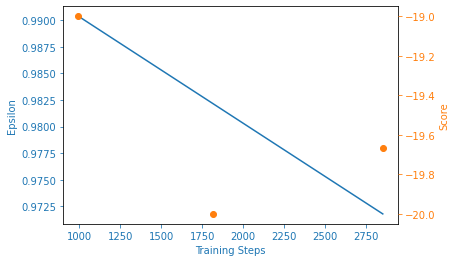

episode:  3 score:  -20.0  average score -19.8 best score -19.00 epsilon 0.96 steps 3816


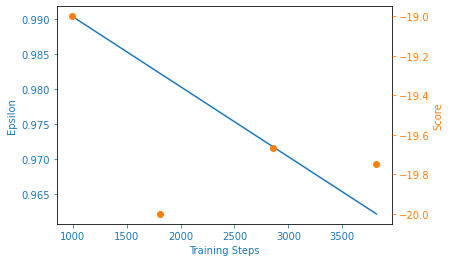

episode:  4 score:  -21.0  average score -20.0 best score -19.00 epsilon 0.95 steps 4668


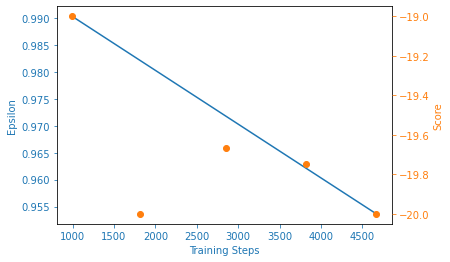

episode:  5 score:  -18.0  average score -19.7 best score -19.00 epsilon 0.94 steps 5732


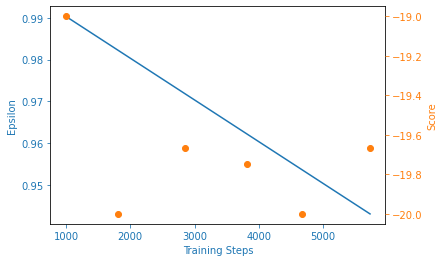

episode:  6 score:  -18.0  average score -19.4 best score -19.00 epsilon 0.93 steps 6897


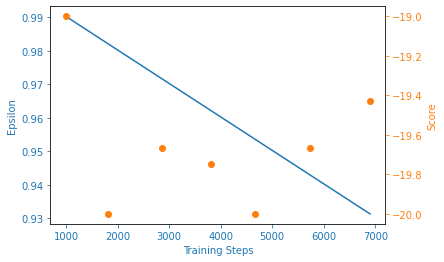

episode:  7 score:  -21.0  average score -19.6 best score -19.00 epsilon 0.92 steps 7809


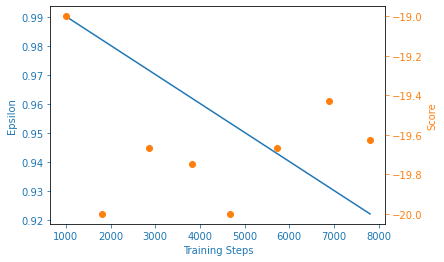

episode:  8 score:  -21.0  average score -19.8 best score -19.00 epsilon 0.91 steps 8573


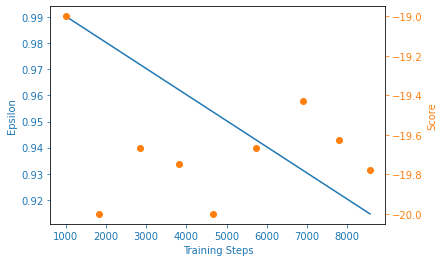

episode:  9 score:  -19.0  average score -19.7 best score -19.00 epsilon 0.90 steps 9675


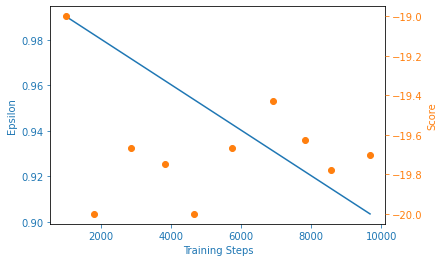

episode:  10 score:  -20.0  average score -19.7 best score -19.00 epsilon 0.89 steps 10622


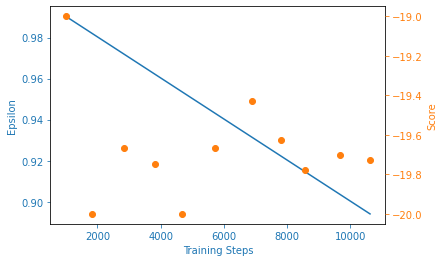

episode:  11 score:  -21.0  average score -19.8 best score -19.00 epsilon 0.89 steps 11386


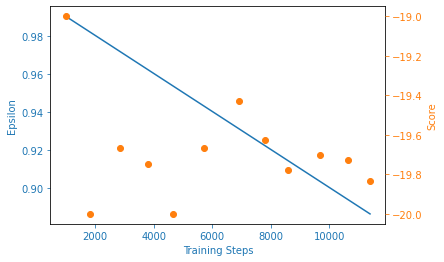

episode:  12 score:  -21.0  average score -19.9 best score -19.00 epsilon 0.88 steps 12150


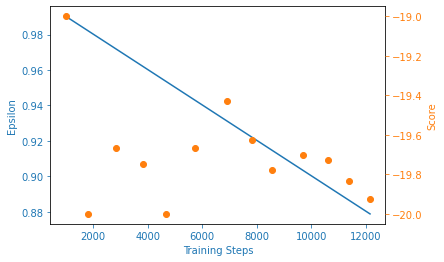

episode:  13 score:  -20.0  average score -19.9 best score -19.00 epsilon 0.87 steps 13099


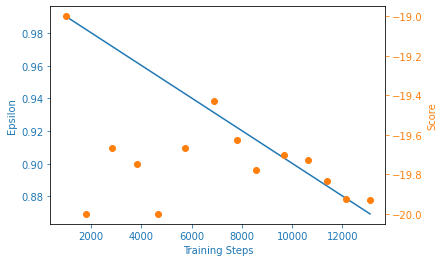

episode:  14 score:  -21.0  average score -20.0 best score -19.00 epsilon 0.86 steps 13863


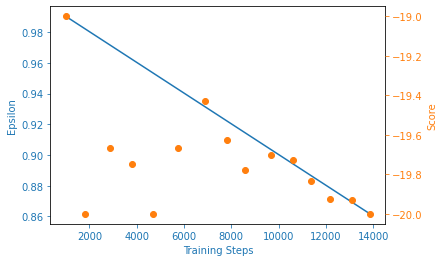

episode:  15 score:  -21.0  average score -20.1 best score -19.00 epsilon 0.85 steps 14646


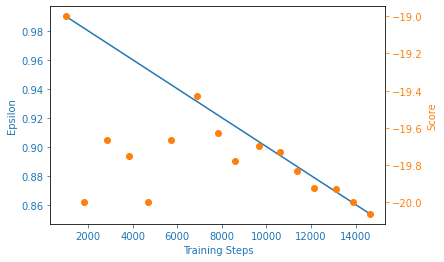

episode:  16 score:  -21.0  average score -20.1 best score -19.00 epsilon 0.85 steps 15438


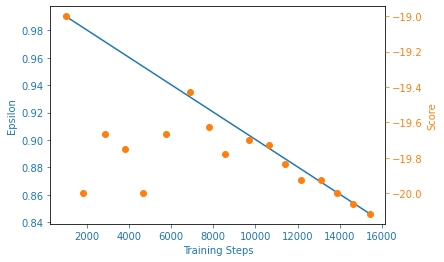

episode:  17 score:  -21.0  average score -20.2 best score -19.00 epsilon 0.84 steps 16290


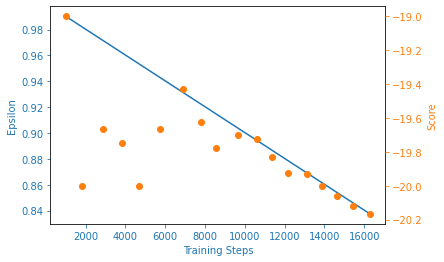

episode:  18 score:  -21.0  average score -20.2 best score -19.00 epsilon 0.83 steps 17234


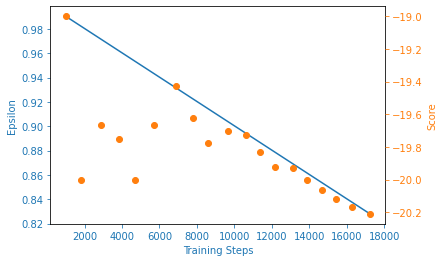

episode:  19 score:  -21.0  average score -20.2 best score -19.00 epsilon 0.82 steps 17998


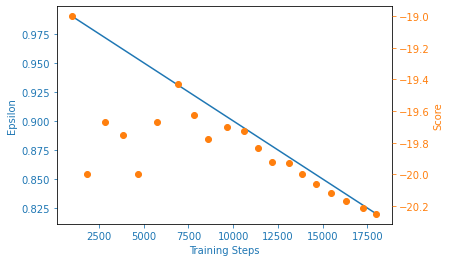

episode:  20 score:  -21.0  average score -20.3 best score -19.00 epsilon 0.81 steps 18822


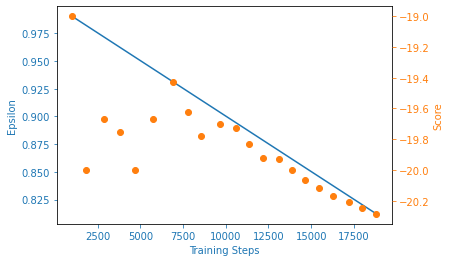

episode:  21 score:  -19.0  average score -20.2 best score -19.00 epsilon 0.80 steps 19815


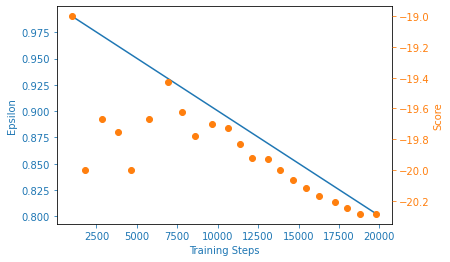

episode:  22 score:  -21.0  average score -20.3 best score -19.00 epsilon 0.79 steps 20579


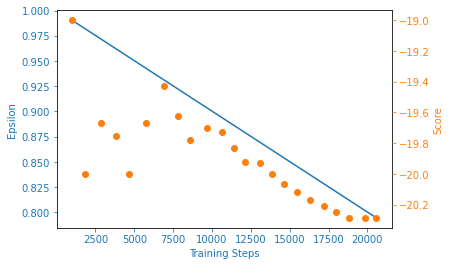

episode:  23 score:  -21.0  average score -20.3 best score -19.00 epsilon 0.79 steps 21343


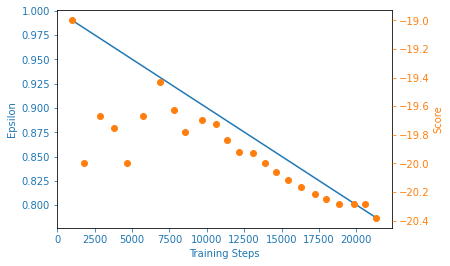

episode:  24 score:  -21.0  average score -20.3 best score -19.00 epsilon 0.78 steps 22107


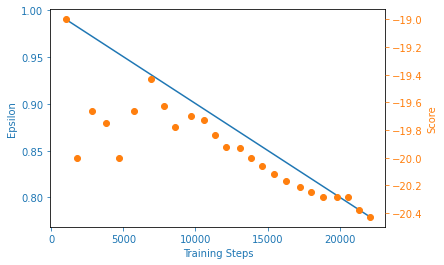

episode:  25 score:  -21.0  average score -20.3 best score -19.00 epsilon 0.77 steps 23021


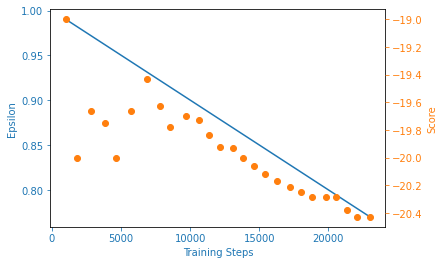

episode:  26 score:  -20.0  average score -20.3 best score -19.00 epsilon 0.76 steps 23864


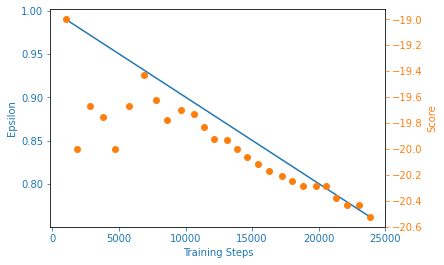

episode:  27 score:  -21.0  average score -20.4 best score -19.00 epsilon 0.75 steps 24688


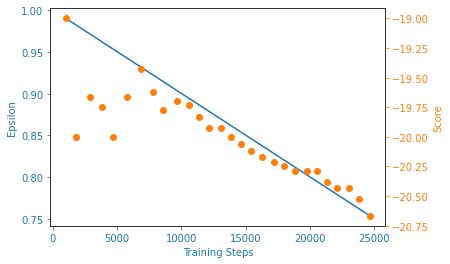

episode:  28 score:  -20.0  average score -20.3 best score -19.00 epsilon 0.74 steps 25591


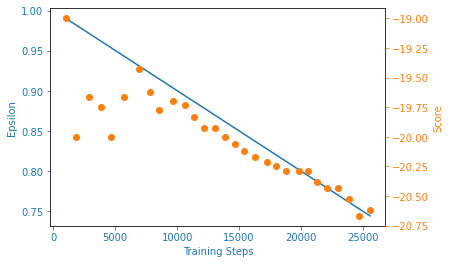

episode:  29 score:  -21.0  average score -20.4 best score -19.00 epsilon 0.74 steps 26355


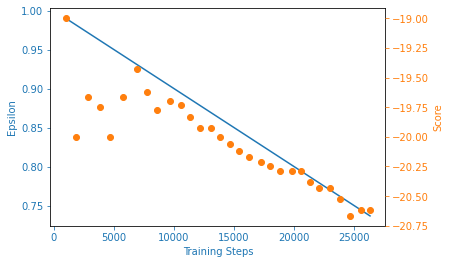

episode:  30 score:  -20.0  average score -20.4 best score -19.00 epsilon 0.73 steps 27198


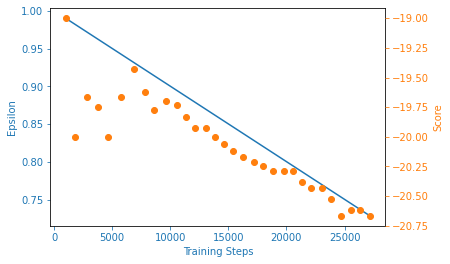

episode:  31 score:  -21.0  average score -20.4 best score -19.00 epsilon 0.72 steps 28024


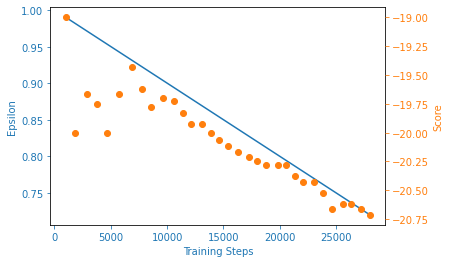

episode:  32 score:  -20.0  average score -20.4 best score -19.00 epsilon 0.71 steps 29050


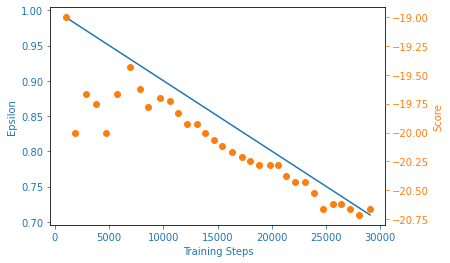

episode:  33 score:  -21.0  average score -20.4 best score -19.00 epsilon 0.70 steps 29814


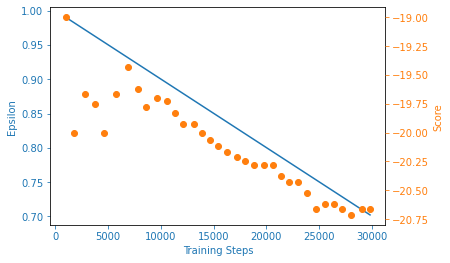

episode:  34 score:  -21.0  average score -20.4 best score -19.00 epsilon 0.69 steps 30756


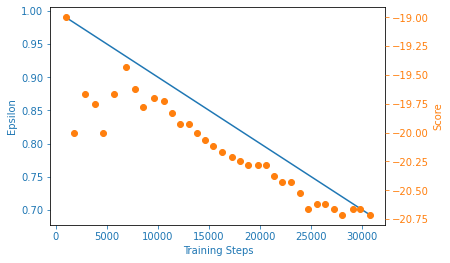

episode:  35 score:  -21.0  average score -20.4 best score -19.00 epsilon 0.68 steps 31539


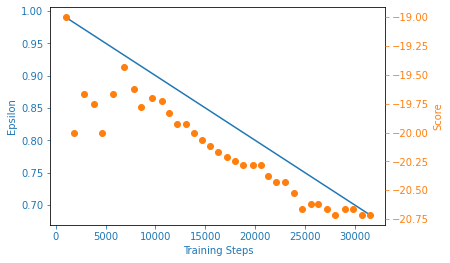

episode:  36 score:  -21.0  average score -20.4 best score -19.00 epsilon 0.68 steps 32363


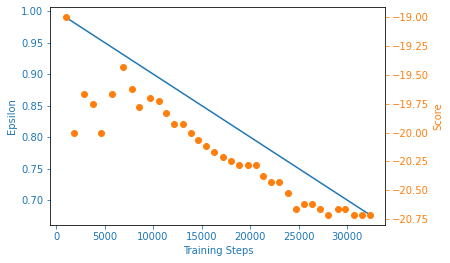

episode:  37 score:  -20.0  average score -20.4 best score -19.00 epsilon 0.67 steps 33312


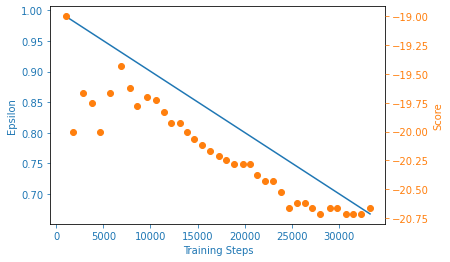

episode:  38 score:  -21.0  average score -20.4 best score -19.00 epsilon 0.66 steps 34076


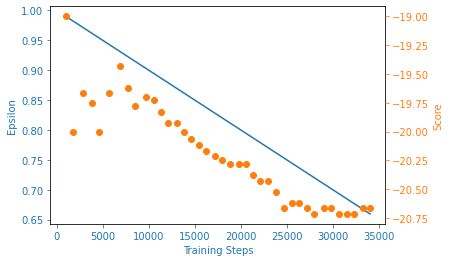

episode:  39 score:  -21.0  average score -20.4 best score -19.00 epsilon 0.65 steps 34840


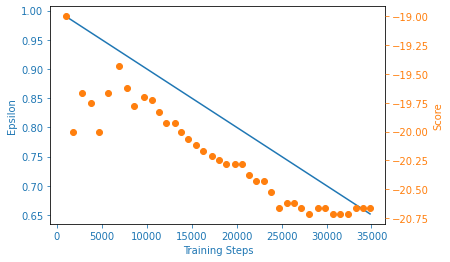

episode:  40 score:  -21.0  average score -20.5 best score -19.00 epsilon 0.64 steps 35604


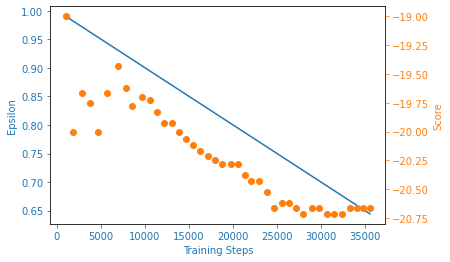

episode:  41 score:  -21.0  average score -20.5 best score -19.00 epsilon 0.64 steps 36368


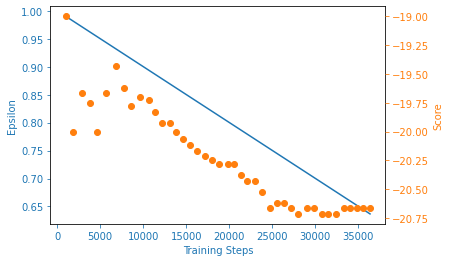

episode:  42 score:  -21.0  average score -20.5 best score -19.00 epsilon 0.63 steps 37132


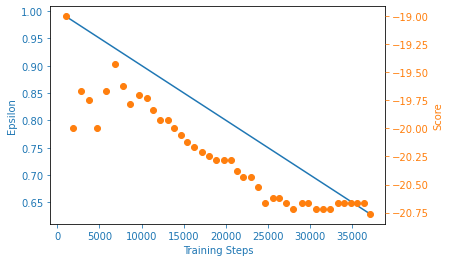

episode:  43 score:  -21.0  average score -20.5 best score -19.00 epsilon 0.62 steps 38059


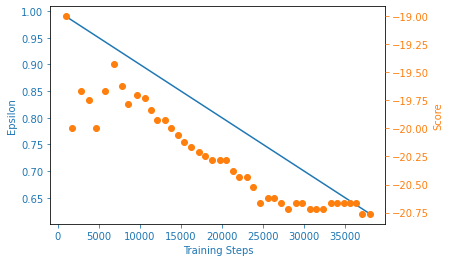

episode:  44 score:  -21.0  average score -20.5 best score -19.00 epsilon 0.61 steps 38841


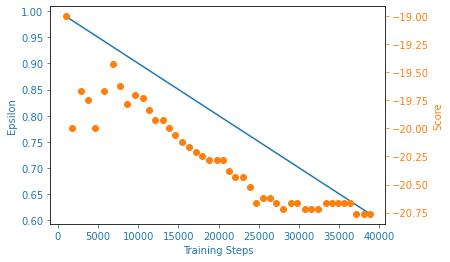

episode:  45 score:  -21.0  average score -20.5 best score -19.00 epsilon 0.60 steps 39605


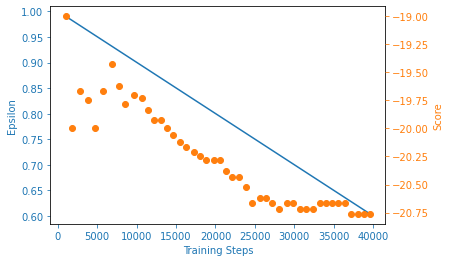

episode:  46 score:  -21.0  average score -20.5 best score -19.00 epsilon 0.60 steps 40458


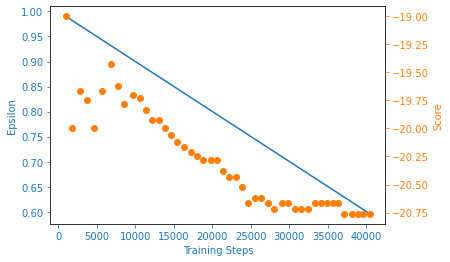

episode:  47 score:  -21.0  average score -20.5 best score -19.00 epsilon 0.59 steps 41284


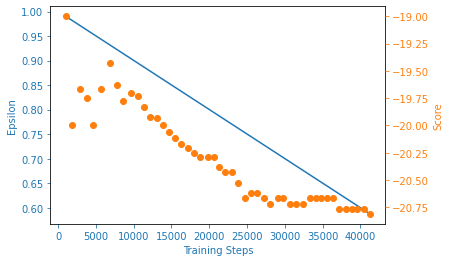

episode:  48 score:  -21.0  average score -20.6 best score -19.00 epsilon 0.58 steps 42048


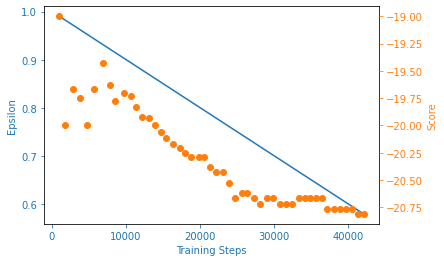

episode:  49 score:  -20.0  average score -20.5 best score -19.00 epsilon 0.57 steps 42950


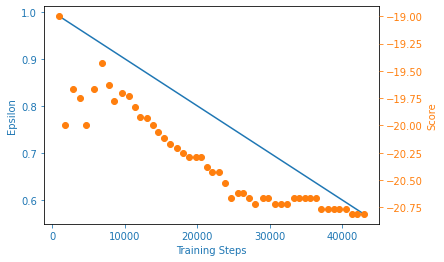

episode:  50 score:  -21.0  average score -20.5 best score -19.00 epsilon 0.56 steps 43774


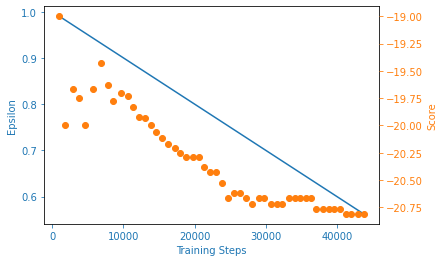

episode:  51 score:  -21.0  average score -20.6 best score -19.00 epsilon 0.55 steps 44557


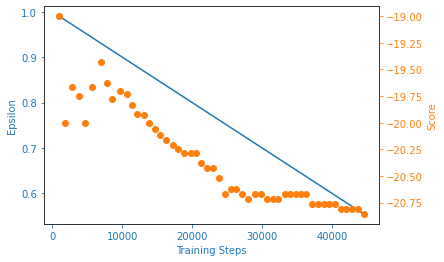

episode:  52 score:  -20.0  average score -20.5 best score -19.00 epsilon 0.55 steps 45395


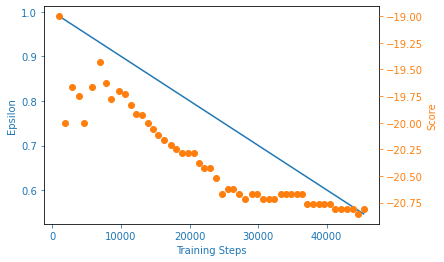

episode:  53 score:  -21.0  average score -20.6 best score -19.00 epsilon 0.54 steps 46219


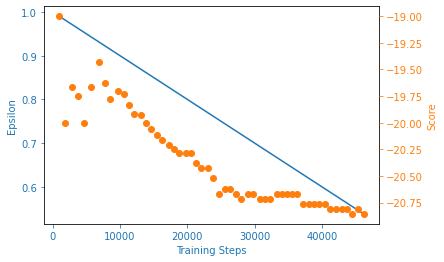

episode:  54 score:  -19.0  average score -20.5 best score -19.00 epsilon 0.53 steps 47195


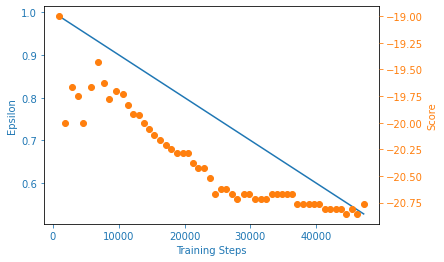

episode:  55 score:  -21.0  average score -20.5 best score -19.00 epsilon 0.52 steps 48019


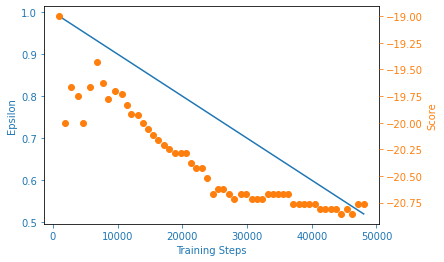

episode:  56 score:  -21.0  average score -20.5 best score -19.00 epsilon 0.51 steps 48839


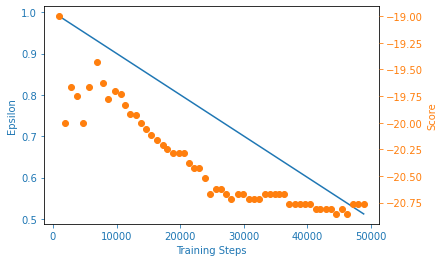

episode:  57 score:  -20.0  average score -20.5 best score -19.00 epsilon 0.50 steps 49682


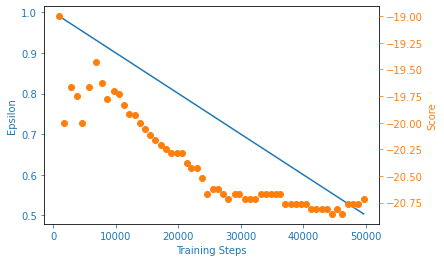

episode:  58 score:  -20.0  average score -20.5 best score -19.00 epsilon 0.50 steps 50520


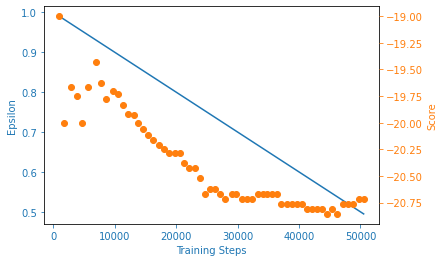

episode:  59 score:  -20.0  average score -20.5 best score -19.00 epsilon 0.49 steps 51390


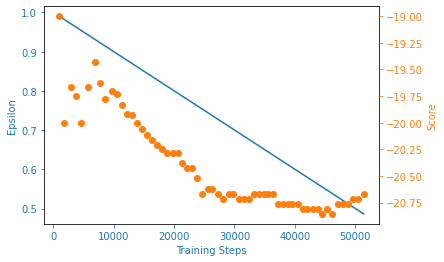

episode:  60 score:  -20.0  average score -20.5 best score -19.00 epsilon 0.48 steps 52228


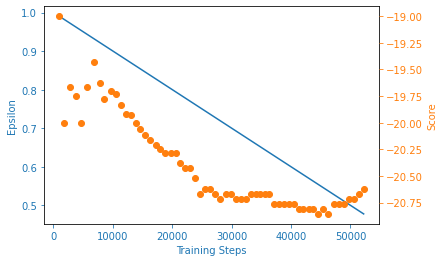

episode:  61 score:  -21.0  average score -20.5 best score -19.00 epsilon 0.47 steps 52992


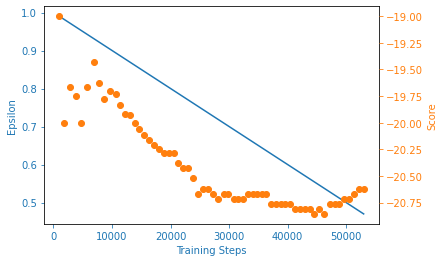

episode:  62 score:  -21.0  average score -20.5 best score -19.00 epsilon 0.46 steps 53756


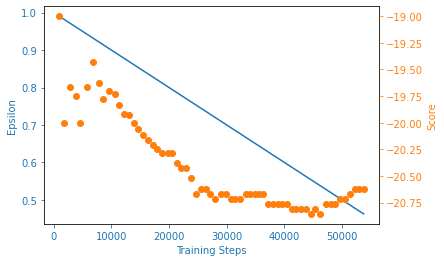

episode:  63 score:  -21.0  average score -20.5 best score -19.00 epsilon 0.45 steps 54576


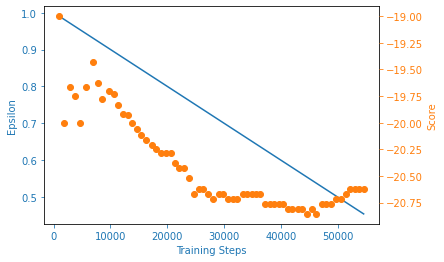

episode:  64 score:  -21.0  average score -20.5 best score -19.00 epsilon 0.45 steps 55415


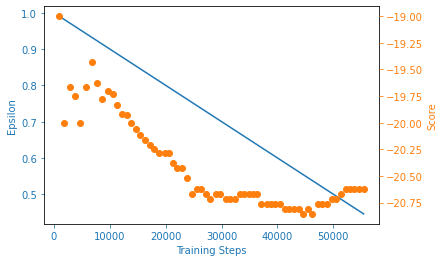

episode:  65 score:  -21.0  average score -20.5 best score -19.00 epsilon 0.44 steps 56255


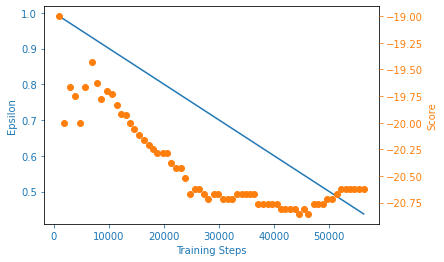

episode:  66 score:  -21.0  average score -20.6 best score -19.00 epsilon 0.43 steps 57019


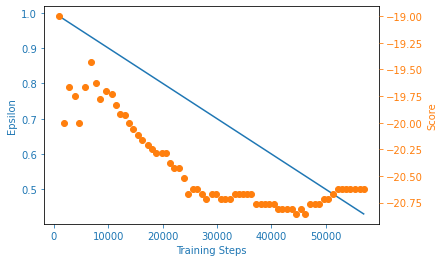

episode:  67 score:  -21.0  average score -20.6 best score -19.00 epsilon 0.42 steps 57783


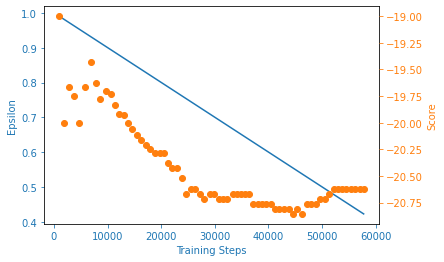

episode:  68 score:  -21.0  average score -20.6 best score -19.00 epsilon 0.41 steps 58547


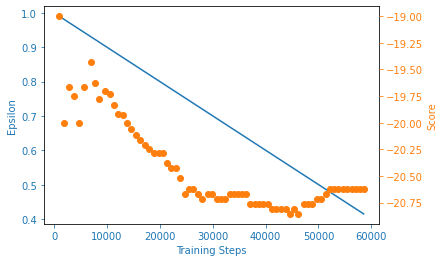

episode:  69 score:  -21.0  average score -20.6 best score -19.00 epsilon 0.41 steps 59311


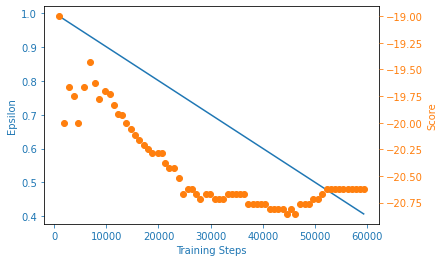

episode:  70 score:  -21.0  average score -20.6 best score -19.00 epsilon 0.40 steps 60075


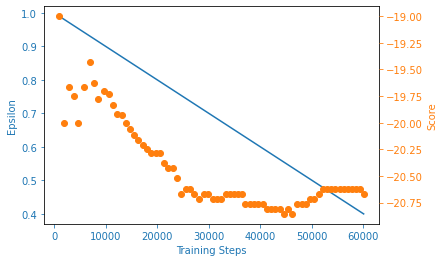

episode:  71 score:  -21.0  average score -20.6 best score -19.00 epsilon 0.39 steps 60839


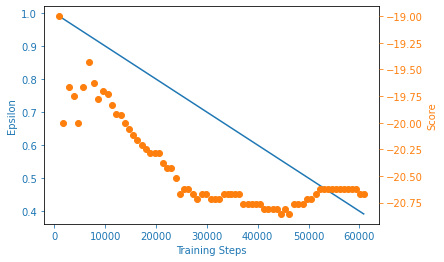

episode:  72 score:  -21.0  average score -20.6 best score -19.00 epsilon 0.38 steps 61603


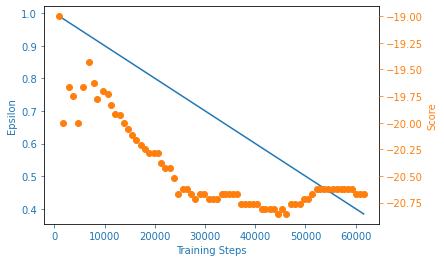

episode:  73 score:  -21.0  average score -20.6 best score -19.00 epsilon 0.38 steps 62367


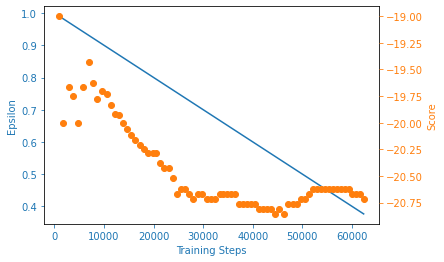

episode:  74 score:  -21.0  average score -20.6 best score -19.00 epsilon 0.37 steps 63131


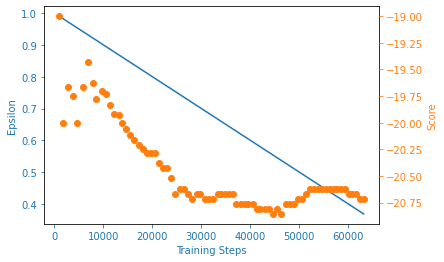

episode:  75 score:  -21.0  average score -20.6 best score -19.00 epsilon 0.36 steps 63895


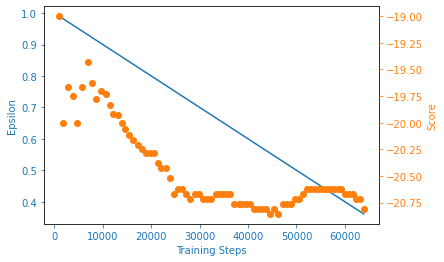

episode:  76 score:  -21.0  average score -20.6 best score -19.00 epsilon 0.35 steps 64720


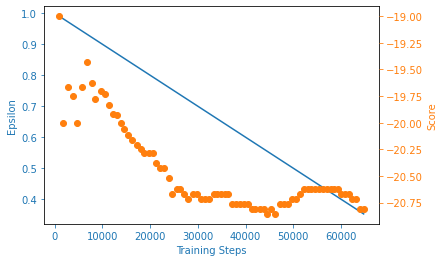

episode:  77 score:  -21.0  average score -20.6 best score -19.00 epsilon 0.34 steps 65544


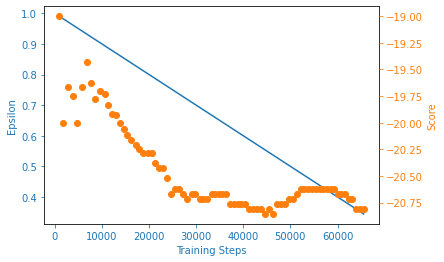

episode:  78 score:  -21.0  average score -20.6 best score -19.00 epsilon 0.34 steps 66368


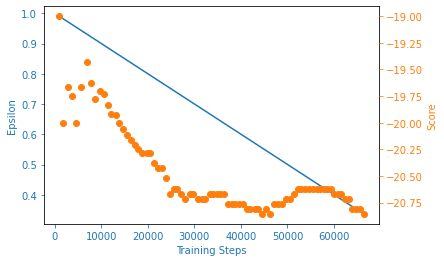

episode:  79 score:  -21.0  average score -20.6 best score -19.00 epsilon 0.33 steps 67194


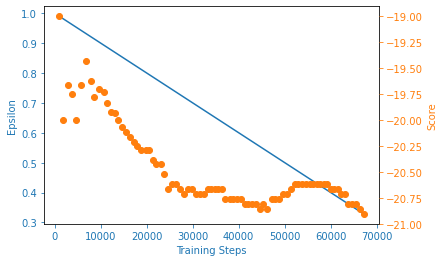

episode:  80 score:  -21.0  average score -20.6 best score -19.00 epsilon 0.32 steps 67958


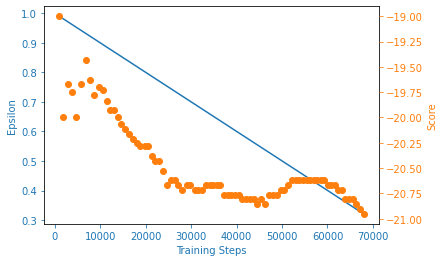

episode:  81 score:  -21.0  average score -20.6 best score -19.00 epsilon 0.31 steps 68722


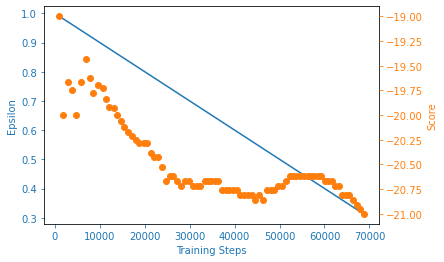

episode:  82 score:  -21.0  average score -20.6 best score -19.00 epsilon 0.31 steps 69486


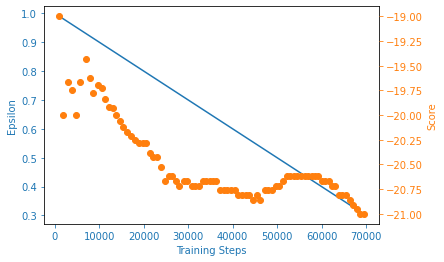

episode:  83 score:  -21.0  average score -20.6 best score -19.00 epsilon 0.30 steps 70372


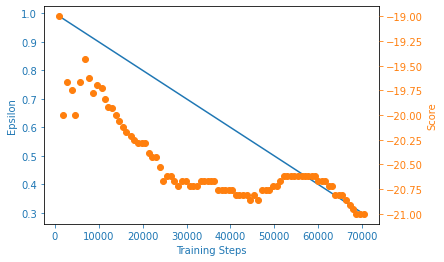

episode:  84 score:  -21.0  average score -20.6 best score -19.00 epsilon 0.29 steps 71258


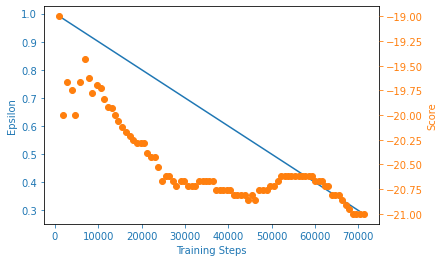

episode:  85 score:  -21.0  average score -20.7 best score -19.00 epsilon 0.28 steps 72084


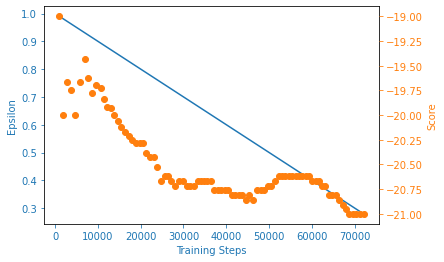

episode:  86 score:  -21.0  average score -20.7 best score -19.00 epsilon 0.27 steps 72908


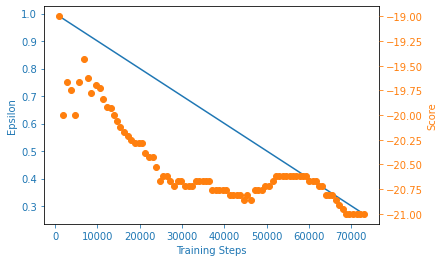

episode:  87 score:  -21.0  average score -20.7 best score -19.00 epsilon 0.26 steps 73734


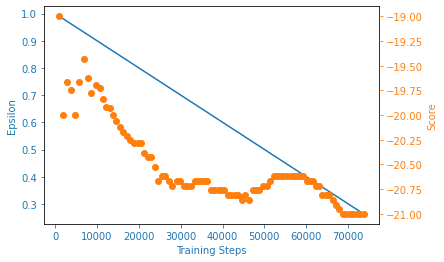

episode:  88 score:  -21.0  average score -20.7 best score -19.00 epsilon 0.25 steps 74560


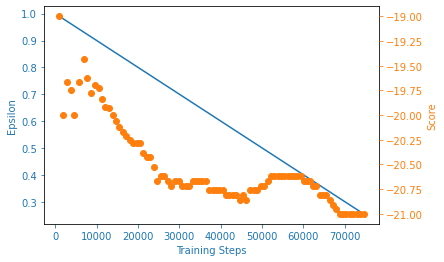

episode:  89 score:  -20.0  average score -20.7 best score -19.00 epsilon 0.25 steps 75402


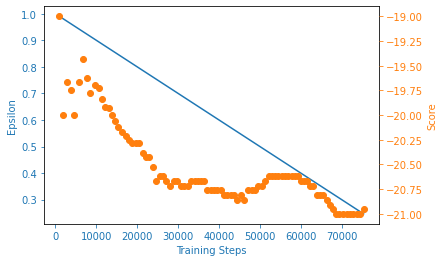

episode:  90 score:  -21.0  average score -20.7 best score -19.00 epsilon 0.24 steps 76185


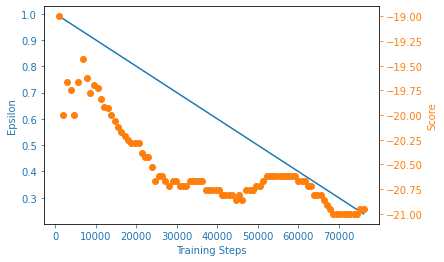

episode:  91 score:  -20.0  average score -20.7 best score -19.00 epsilon 0.23 steps 77027


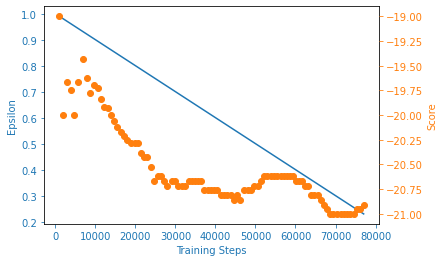

episode:  92 score:  -20.0  average score -20.6 best score -19.00 epsilon 0.22 steps 77865


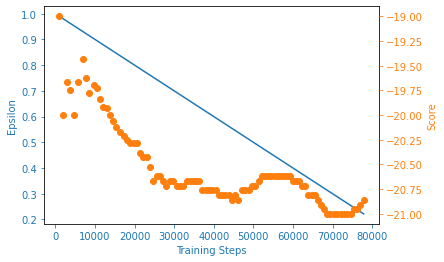

episode:  93 score:  -21.0  average score -20.6 best score -19.00 epsilon 0.21 steps 78629


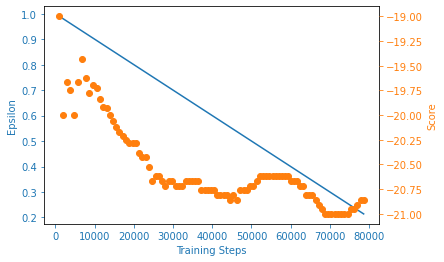

episode:  94 score:  -20.0  average score -20.6 best score -19.00 epsilon 0.21 steps 79471


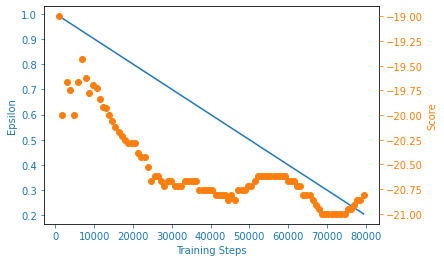

In [ ]:
env = make_env('PongNoFrameskip-v4')
best_score = -np.inf
load_checkpoint = False
n_games = 250

agent = DualDQNAgent(gamma=0.99, epsilon=1, lr=0.0005,
                     input_dims=(env.observation_space.shape),
                     n_actions=env.action_space.n, mem_size=20000, eps_min=0.1,
                     batch_size=32, replace=1000, eps_dec=1e-5,
                     chkpt_dir='./', algo='DQNAgent',
                     env_name='PongNoFrameskip-v4')

if load_checkpoint:
    agent.load_models()

fname = agent.algo + '_' + agent.env_name + '_lr' + str(agent.lr) + '_' + str(n_games) + 'games'
figure_file = 'plots/' + fname + '.png'
# if you want to record video of your agent playing, do a mkdir tmp && mkdir tmp/dqn-video
# and uncomment the following 2 lines.
# env = wrappers.Monitor(env, "tmp/dqn-video",
#                    video_callable=lambda episode_id: True, force=True)
n_steps = 0
scores, eps_history, steps_array = [], [], []

for i in range(n_games):
    done = False
    observation = env.reset()

    score = 0
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        score += reward

        if not load_checkpoint:
            agent.store_transition(observation, action, reward, observation_, done)
            agent.learn()
            observation = observation_
            n_steps += 1

    scores.append(score)
    steps_array.append(n_steps)

    avg_score = np.mean(scores[-100:])
    print('episode: ', i,'score: ', score,
        ' average score %.1f' % avg_score, 'best score %.2f' % best_score,
        'epsilon %.2f' % agent.epsilon, 'steps', n_steps)

    if avg_score > best_score:
        if not load_checkpoint:
            agent.save_models()
        best_score = avg_score

    eps_history.append(agent.epsilon)

    x = [i+1 for i in range(len(scores))]
    plot_learning_curve(steps_array, scores, eps_history)